In [5]:
import torch
import torch.nn.functional as F
from models import PE, BlockMLP
from kornia import create_meshgrid
from einops import rearrange, reduce, repeat
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np
from metrics import psnr


device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_wh = (4096, 4096)
patch_wh = (32, 32)
n_scales = 4
n_layers = 3
n_hidden = 20
exp_name = f'pluto4k_{n_scales}scale_pe'

n_freq = 4
P = torch.cat([torch.eye(2)*2**i for i in range(n_freq)], 1)
pe = PE(P).to(device)

uv = create_meshgrid(patch_wh[1], patch_wh[0], device=device)

rgb_gt = np.float32(Image.open('images/pluto.png').convert('RGB'))/255.
rgb_gt = cv2.resize(rgb_gt, (img_wh[0], img_wh[1]))

In [6]:
t = time.time()
for j in reversed(range(n_scales)):
    rgb_gt_ = cv2.resize(rgb_gt, None, fx=1/2**j, fy=1/2**j)
    
    final_act = 'sigmoid' if j==n_scales-1 else 'sin'
    nh = img_wh[1]//(patch_wh[1]*2**j)
    nw = img_wh[0]//(patch_wh[0]*2**j)
    ckpt = torch.load(f'ckpts/{exp_name}/subimg000/l{j}.ckpt', map_location=torch.device('cpu'))
    active_blocks = ckpt['active_blocks']
    n_blocks = int(active_blocks.sum())
    blockmlp = BlockMLP(n_blocks=n_blocks,
                        n_in=pe.out_dim, n_out=3,
                        n_layers=n_layers,
                        n_hidden=n_hidden,
                        final_act=final_act).to(device)
    blockmlp.load_state_dict(ckpt, strict=False)

    uv_ = repeat(uv, '1 ph pw c -> n (ph pw) c', n=n_blocks)
    
    with torch.no_grad():
        rgb_pred_ = blockmlp(pe(uv_), to_cpu=True)
        if j <= n_scales-2:
            rgb_pred_ *= ckpt['scales']
    torch.cuda.synchronize()

    rgb_pred = torch.zeros(nh*nw, patch_wh[1]*patch_wh[0], 3)
    rgb_pred[active_blocks] = rgb_pred_
    rgb_pred = rearrange(rgb_pred,
                         '(nh nw) (ph pw) c -> (nh ph) (nw pw) c',
                         nh=nh, nw=nw, ph=patch_wh[1], pw=patch_wh[0])
    if j <= n_scales-2:
        rgb_pred += I_j_u
        rgb_pred = np.clip(rgb_pred, 0, 1)

    I_j_u = F.interpolate(rearrange(rgb_pred, 'h w c -> 1 c h w'),
                          mode='bilinear',
                          scale_factor=2,
                          align_corners=True)
    I_j_u = rearrange(I_j_u, '1 c h w -> h w c')

print(f'total time {time.time()-t:.3f} s')
print(f'PSNR {psnr(rgb_pred.numpy(), rgb_gt_):.2f} dB')

total time 2.692 s
PSNR 42.18 dB


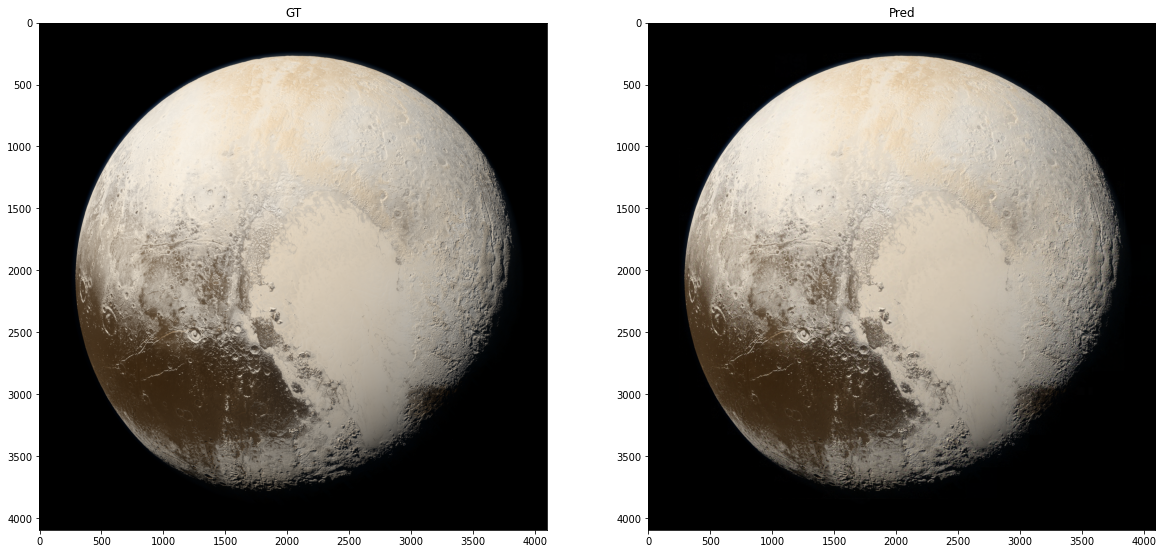

In [7]:
plt.subplots(figsize=(20, 20))
plt.subplot(121)
plt.title('GT')
plt.imshow(rgb_gt)
plt.subplot(122)
plt.title('Pred')
plt.imshow(rgb_pred);